In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from Firm import Firm
from stable_baselines3 import DQN
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

## Print Example Action- and Observation-Space

In [2]:
f = Firm(False)
print("action_space = ",[f.action_space.sample() for i in range(20)], " observation_space = ", f.observation_space)

Selected Scenario:  scenario4
action_space =  [0, 28, 19, 32, 20, 9, 19, 22, 2, 27, 21, 3, 14, 28, 39, 19, 31, 38, 25, 36]  observation_space =  Dict(action_mask:Box([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], (41,), float64), real_obs:Box([[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0.

### Custom Callback function to save best agent and measure training time

In [3]:
class SaveAgentProgressCallback(BaseCallback):
    
    def __init__(self, log_dir, check_freq, verbose=1):
        super(SaveAgentProgressCallback, self).__init__(verbose)
        self.start_time = None
        self.end_time = None
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model_DQN")
        self.check_freq = check_freq
        self.best_mean_reward = -np.inf
        self.step_time = []
        
    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self) -> bool:
        if len(self.step_time) == 0:
            self.step_time.append(time.time())
        else:
            self.step_time.append(time.time()-self.step_time[0])
        
        if self.n_calls % self.check_freq == 0:
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Calculate Mean reward over last episodes
                mean_reward = np.mean(y[-8:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}, Average step time: {sum(self.step_time[1:]) / (len(self.step_time) - 1)}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")
                    
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}")
                        self.model.save(self.save_path)
                # reset step_time list
            self.step_time = []
            
        # Set new base time 
        if len(self.step_time) == 0:
            self.step_time.append(time.time())
        else:
            self.step_time[0] = time.time()
        return True

    def _on_training_start(self):
        self.start_time = time.time()
    
    def _on_training_end(self):
        self.end_time = time.time()
        print(f"Training time: {(self.end_time - self.start_time) / 60}")
        

### Train model

In [4]:
log_path = os.path.join("Training", "Logs")

env = Firm(late_delivery=False, downtime=False, downtime_total=False, diminishing_value=1.0, wip=False)
env = Monitor(env, log_path)

model = DQN("MultiInputPolicy", env, verbose=1)

Selected Scenario:  scenario4
Using cuda device
Wrapping the env in a DummyVecEnv.


In [5]:
timesteps = 200000
callback = SaveAgentProgressCallback(log_path, 10000)

In [6]:
model.learn(total_timesteps=timesteps, callback=callback)

Selected Scenario:  scenario0
Selected Scenario:  scenario1
Num timesteps: 20000, Average step time: 0.00035447940826416016
Best mean reward: -inf - Last mean reward per episode: -12651.50
Saving new best model to Training\Logs\best_model_DQN
Num timesteps: 30000, Average step time: 0.0002689604759216309
Best mean reward: -12651.50 - Last mean reward per episode: -12651.50
Selected Scenario:  scenario4
Num timesteps: 40000, Average step time: 0.0002770620107650757
Best mean reward: -12651.50 - Last mean reward per episode: -12075.15
Saving new best model to Training\Logs\best_model_DQN
Selected Scenario:  scenario1
Num timesteps: 50000, Average step time: 0.0002763445138931274
Best mean reward: -12075.15 - Last mean reward per episode: -12165.83
Num timesteps: 60000, Average step time: 0.0022415332317352295
Best mean reward: -12075.15 - Last mean reward per episode: -12165.83
Num timesteps: 70000, Average step time: 0.0020582608222961428
Best mean reward: -12075.15 - Last mean reward p

### Display Training Curve

<AxesSubplot:xlabel='Episode', ylabel='r'>

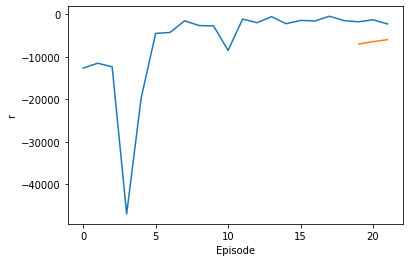

In [7]:
import pandas as pd
import seaborn as sns

# Moving Average einbauen
df = pd.read_csv(f"{log_path}/monitor.csv", skiprows=1)
df["Episode"] = [i for i in range(len(df))]
df["20EA"] = df["r"].rolling(20).mean()
sub_df = df[:-10]
sns.lineplot(data=sub_df, x="Episode", y="r")
sns.lineplot(data=sub_df, x="Episode", y="20EA")

In [8]:
model_name = "Temp"
save_path = os.path.join("SavedModels", model_name)

In [9]:
model.save(save_path)

In [11]:
episodes = 1

while episodes > 0:
    obs = env.reset(eval=True)
    done = False
    score = 0
    
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
    
    env.render()
    episodes -= 1
    print(f"Score: {score}", env.time, env.calculate_profit(), env.time*env.fix_costs)
    print(f"late jobs: {len(env.late_jobs)}")
    print(f"Illegal_move: {env.temp_illegal_move}")
    print(f"job_complete_active = {env.temp_job_ca_penalty}")
    print(f"No_legal_action = {env.temp_no_legal_action}")
    print(f"advance_time_penalty = {env.advance_time_penalty}")


Selected Scenario:  evalscenario


Score: -24308.5 705 -30735.0 105750
late jobs: 40
Illegal_move: -276
job_complete_active = -20254
No_legal_action = 0
advance_time_penalty = -655
